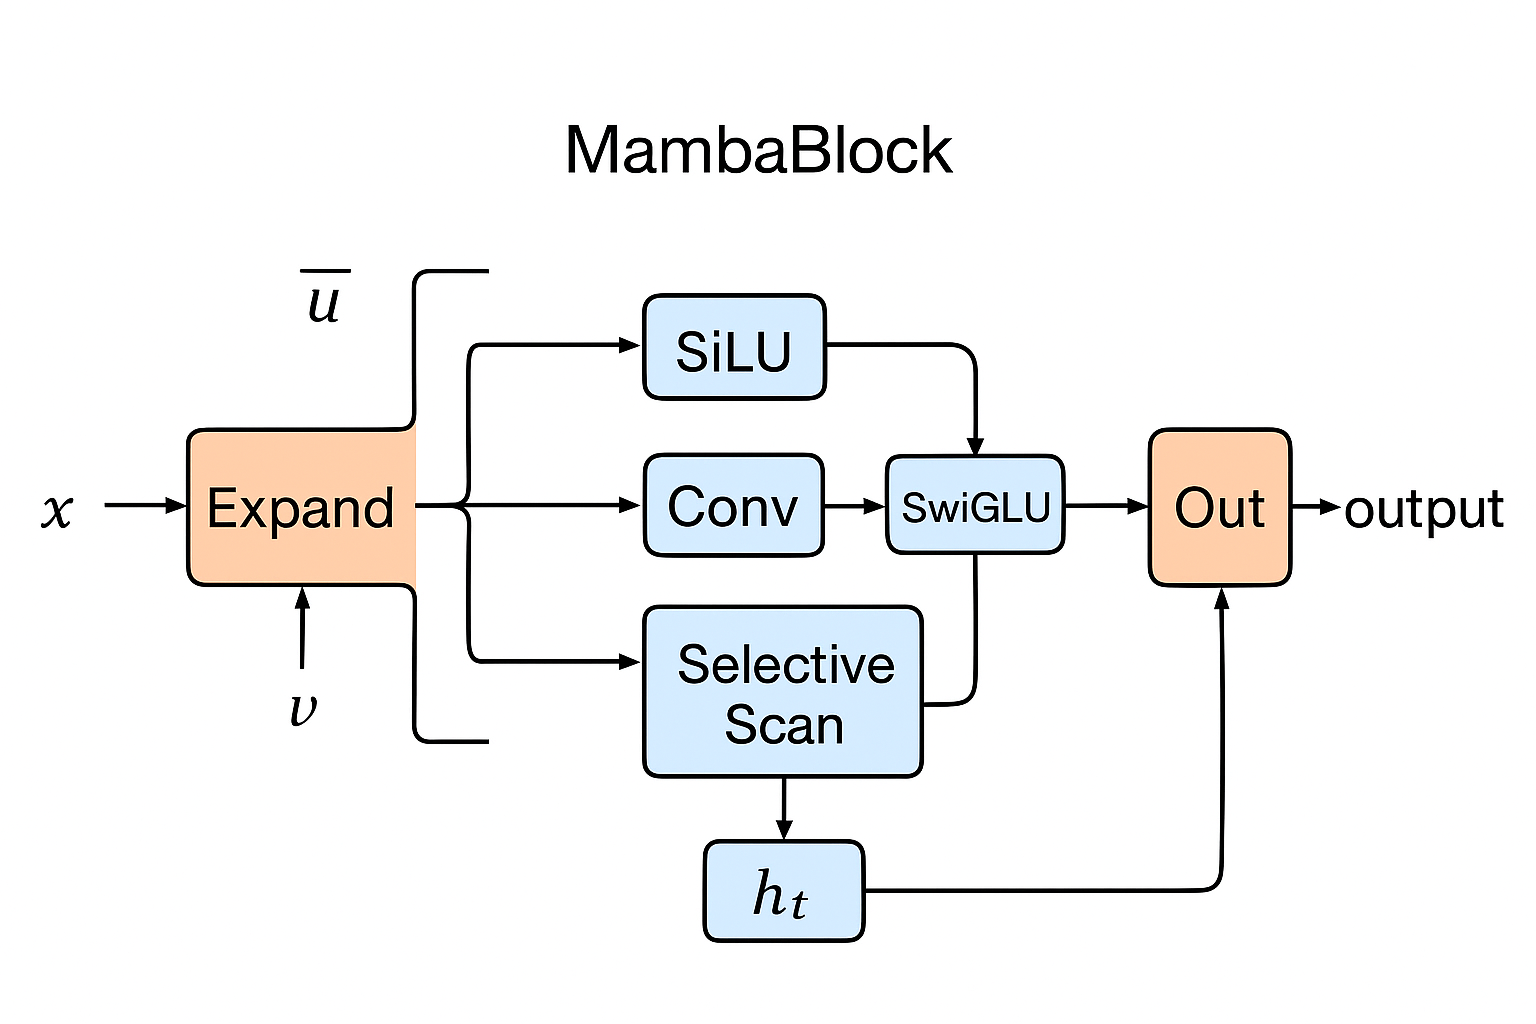

𝑋 → [𝗎,v]

In [1]:
with open('/content/input.txt', 'r', encoding='utf-8') as f:
    x = f.read()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ExpandProjection(nn.Module):
    def __init__(self, d_model, expansion_factor=2):
        super().__init__()
        self.d_model = d_model
        self.expansion_factor = expansion_factor
        self.proj = nn.Linear(d_model, expansion_factor * d_model)

    def forward(self, x):
        """
        x: (batch, seq_len, d_model)
        return: u, v — две половины expand-проекции
        """
        # линейное преобразование (batch, seq_len, E*D)
        expanded = self.proj(x)

        # делим на две части (u и v), каждая по размерности E*D/2
        u, v = expanded.chunk(2, dim=-1)
        return u, v

# пример использования
B, L, D = 4, 16, 64
x = torch.randn(B, L, D)

expand = ExpandProjection(D, expansion_factor=2)
u, v = expand(x)

print(u.shape, v.shape)  # -> torch.Size([4, 16, 64]) torch.Size([4, 16, 64])


torch.Size([4, 16, 64]) torch.Size([4, 16, 64])


In [3]:

class TemporalConv(nn.Module):
    def __init__(self, d_model, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels=d_model,
            out_channels=d_model,
            kernel_size=kernel_size,
            padding=kernel_size // 2,  # чтобы сохранить длину L
            groups=d_model,            # depthwise conv
            bias=True
        )

    def forward(self, v):
        """
        v: (batch, seq_len, d_model)
        return: v': (batch, seq_len, d_model)
        """
        # переставляем оси для Conv1d
        v = v.transpose(1, 2)          # (batch, d_model, seq_len)
        v = self.conv(v)               # применяем depthwise conv
        v = v.transpose(1, 2)          # возвращаем (batch, seq_len, d_model)
        return v

# пример использования
B, L, D = 4, 16, 64
v = torch.randn(B, L, D)

conv = TemporalConv(D, kernel_size=3)
v_out = conv(v)

print(v_out.shape)  # -> torch.Size([4, 16, 64])


torch.Size([4, 16, 64])


In [4]:
def sigmoid(x):
  return 1/(1+torch.exp(x*-1))

In [5]:
def silu(x):
  return x * sigmoid(x)
g = silu(u)

In [6]:


class DeltaProjection(nn.Module):
    def __init__(self, d_model, r=1):
        super().__init__()
        self.r = r
        self.proj_in = nn.Linear(d_model, r)   # Linear_D->R
        # если r > 1, делаем low-rank Linear(R->D)
        self.proj_out = None
        if r > 1:
            self.proj_out = nn.Linear(r, d_model)

    def forward(self, x):
        """
        x: (batch, seq_len, d_model)
        return: Δ: (batch, seq_len, d_model)
        """
        delta_r = self.proj_in(x)                # (B, L, R)
        delta_r = F.softplus(delta_r)            # гарантируем > 0

        if self.r == 1:
            # broadcast скаляра на D каналов
            delta = delta_r.expand(-1, -1, x.size(-1))  # (B, L, D)
        else:
            # low-rank проекция R->D
            delta = self.proj_out(delta_r)       # (B, L, D)

        return delta

# пример
B, L, D = 2, 5, 4
x = torch.randn(B, L, D)

proj = DeltaProjection(d_model=D, r=1)
delta = proj(x)

print(delta.shape)  # torch.Size([2, 5, 4])
print(delta)        # положительные значения (>0)


torch.Size([2, 5, 4])
tensor([[[0.4301, 0.4301, 0.4301, 0.4301],
         [0.3135, 0.3135, 0.3135, 0.3135],
         [0.6574, 0.6574, 0.6574, 0.6574],
         [0.8326, 0.8326, 0.8326, 0.8326],
         [0.7580, 0.7580, 0.7580, 0.7580]],

        [[0.7163, 0.7163, 0.7163, 0.7163],
         [0.5619, 0.5619, 0.5619, 0.5619],
         [0.3549, 0.3549, 0.3549, 0.3549],
         [0.5700, 0.5700, 0.5700, 0.5700],
         [1.1429, 1.1429, 1.1429, 1.1429]]], grad_fn=<ExpandBackward0>)


In [7]:

class ZOHDiagonal:
    """
    A_diag:  (N,)       или (D, N)  — собственные значения A (диагональ).
    B_vec:   (N,)       или (D, N)  — вектор B для скалярного входа.
    Δ (delta): (B, L, D) — селективный шаг дискретизации на каждом токене/канале.
    Возвращает:
      A_t: (B, L, D, N) — поэлементная exp(Δ * A)
      B_t: (B, L, D, N) — поэлементная (expm1(Δ*A)/A) * B
    """
    def __init__(self, A_diag, B_vec):
        # A_diag, B_vec — тензоры параметров, регистрируем как буферы/параметры вне этого класса
        self.A_diag = A_diag  # (N,) или (D,N)
        self.B_vec  = B_vec   # (N,) или (D,N)

    @staticmethod
    def _expand_to_DN(x, target_shape):
        # helper для приведения (N,) или (D,N) к (..., D, N)
        if x.dim() == 1:
            # (N,) -> (1, D, N) потом broadcast
            x = x.unsqueeze(0)  # (1, N)
            x = x.unsqueeze(0)  # (1, 1, N)
        elif x.dim() == 2:
            # (D, N) -> (1, D, N)
            x = x.unsqueeze(0)
        else:
            raise ValueError("A_diag/B_vec must be (N,) or (D,N)")
        # теперь x — (1, D?, N). target_shape = (B, L, D, N)
        B, L, D, N = target_shape
        if x.size(-1) != N:
            raise ValueError("N mismatch")
        if x.size(-2) == 1:
            # (1,1,N) или (1,1?,N) -> (1,D,N)
            x = x.expand(1, D, N)
        elif x.size(-2) != D:
            raise ValueError("D mismatch")
        # приведём к (1, D, N) и дадим broadcast по B и L
        x = x.unsqueeze(0).expand(B, D, N)  # (B, D, N)
        x = x.unsqueeze(1).expand(B, L, D, N)  # (B, L, D, N)
        return x

    def __call__(self, delta):
        """
        delta: (B, L, D)
        """
        B, L, D = delta.shape
        # целевая форма для A_t/B_t: (B, L, D, N)
        # N берём из параметров
        N = self.A_diag.size(-1) if self.A_diag.dim() == 2 else self.A_diag.size(0)
        target = (B, L, D, N)

        # растягиваем параметры до (B, L, D, N)
        A = self._expand_to_DN(self.A_diag, target)   # (B, L, D, N)
        Bv = self._expand_to_DN(self.B_vec,  target)  # (B, L, D, N)

        # Δ -> (B, L, D, 1) для поэлементных операций с N
        delta_expanded = delta.unsqueeze(-1)          # (B, L, D, 1)

        # exp(Δ*A) — используем стабильный exp
        DA = delta_expanded * A                       # (B, L, D, N)
        A_t = torch.exp(DA)                           # (B, L, D, N)

        # B_t = (expm1(Δ*A)/A) * B
        # Используем expm1 для устойчивости при малых DA: expm1(x) = e^x - 1
        # Для A≈0 ограничиваемся пределом: expm1(DA)/A -> Δ
        eps = 1e-8
        num = torch.expm1(DA)                         # (B, L, D, N)
        # где |A|<eps — берём эквивалентный предел Δ (серия Тейлора)
        denom_safe = torch.where(A.abs() < eps, torch.ones_like(A), A)
        frac = num / denom_safe                       # (B, L, D, N)
        frac = torch.where(A.abs() < eps, delta_expanded.expand_as(A), frac)
        B_t = frac * Bv                               # (B, L, D, N)

        return A_t, B_t


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelectiveScan(nn.Module):
    """
    Fused selective scan (PyTorch-реализация логики):
    - На каждом t считаем A_t=exp(Δ_t * A), B_t=(expm1(Δ_t*A)/A)*B (устойчиво),
      обновляем состояние h_t = A_t * h_{t-1} + B_t * v_t
    - Сразу считаем z_t = <C, h_t> по оси N (не храним h_t на всю L)
    - Ничего из A_t/B_t не материализуем на всю последовательность

    Формы:
      v:      (B, L, D)          — вход на SSM-ветке
      delta:  (B, L, D)          — селективные шаги Δ_t (>0, см. ваш пункт 5.1)
      A_diag: (N,)   или (D, N)  — диагональные элементы матрицы A по состояниям
      B_vec:  (N,)   или (D, N)  — вектор B на состояние
      C_vec:  (N,)   или (D, N)  — вектор C (сворачивает состояние в скаляр по каналу)
      h0:     (B, D, N)          — начальное состояние (если None — нули)
    Возвращает:
      z: (B, L, D)               — последовательность выходов z_t
      h_last: (B, D, N)          — финальное состояние (для автогенерации)
    """
    def __init__(self, A_diag: torch.Tensor, B_vec: torch.Tensor, C_vec: torch.Tensor):
        super().__init__()
        # Регистрируем как параметры или буферы — на ваш выбор:
        # Здесь делаем параметрами, чтобы обучались.
        self.A_diag = nn.Parameter(A_diag)  # (N,) или (D,N)
        self.B_vec  = nn.Parameter(B_vec)   # (N,) или (D,N)
        self.C_vec  = nn.Parameter(C_vec)   # (N,) или (D,N)

    @staticmethod
    def _expand_param(p: torch.Tensor, B: int, D: int, N: int, device, dtype):
        """
        Приводит p формы (N,) или (D,N) к батч-совместимой форме (B, D, N) через broadcast.
        Ничего не копирует лишнего: даёт представление для поэлементной арифметики.
        """
        if p.dim() == 1:
            # (N,) -> (1, 1, N) -> (B, D, N) broadcast
            p = p.view(1, 1, N).to(device=device, dtype=dtype).expand(B, D, N)
        elif p.dim() == 2:
            # (D,N) -> (1, D, N) -> (B, D, N) broadcast
            if p.size(0) != D or p.size(1) != N:
                raise ValueError("Param of shape (D,N) must match provided D,N.")
            p = p.view(1, D, N).to(device=device, dtype=dtype).expand(B, D, N)
        else:
            raise ValueError("Param must be of shape (N,) or (D,N)")
        return p

    def forward(self, v: torch.Tensor, delta: torch.Tensor, h0: torch.Tensor = None, chunk_len: int = None):
        """
        v:     (B, L, D)
        delta: (B, L, D)
        h0:    (B, D, N) or None
        chunk_len: опционально — длина чанка по времени, если хотите обрабатывать очень длинные L кусками.
        """
        B, L, D = v.shape
        device, dtype = v.device, v.dtype
        # N берём из параметров
        N = self.A_diag.size(-1) if self.A_diag.dim() == 2 else self.A_diag.size(0)

        # Приводим A,B,C к виду (B, D, N) «ленивым» broadcast'ом
        A_dn = self._expand_param(self.A_diag, B, D, N, device, dtype)  # (B,D,N)
        B_dn = self._expand_param(self.B_vec,  B, D, N, device, dtype)  # (B,D,N)
        C_dn = self._expand_param(self.C_vec,  B, D, N, device, dtype)  # (B,D,N)

        # Инициализация состояния
        if h0 is None:
            h = torch.zeros(B, D, N, device=device, dtype=dtype)
        else:
            if h0.shape != (B, D, N):
                raise ValueError(f"h0 must be (B,D,N), got {h0.shape}")
            h = h0

        # Выход
        z_out = torch.empty(B, L, D, device=device, dtype=dtype)

        # Обработка чанками по времени (если задано), иначе — одним проходом
        if chunk_len is None or chunk_len >= L:
            t_ranges = [(0, L)]
        else:
            t_ranges = []
            start = 0
            while start < L:
                end = min(start + chunk_len, L)
                t_ranges.append((start, end))
                start = end

        eps = 1e-8
        for (t0, t1) in t_ranges:
            # берём срезы v и delta: (B, T, D)
            v_blk = v[:, t0:t1, :]
            d_blk = delta[:, t0:t1, :]

            # последовательно по времени (но на GPU всё ещё батч/каналы параллельны)
            for i in range(t1 - t0):
                vi = v_blk[:, i, :].unsqueeze(-1)   # (B, D, 1)
                di = d_blk[:, i, :].unsqueeze(-1)   # (B, D, 1)

                # A_t = exp(Δ*A)  — поэлементно в (B,D,N)
                DA  = di * A_dn                      # (B, D, N)
                A_t = torch.exp(DA)                  # (B, D, N)

                # B_t = (expm1(Δ*A)/A) * B — устойчиво при малых A
                num = torch.expm1(DA)                # (B, D, N)
                # где |A|<eps, используем предел: expm1(DA)/A -> Δ
                denom = torch.where(A_dn.abs() < eps,
                                    torch.ones_like(A_dn),
                                    A_dn)
                frac = num / denom
                frac = torch.where(A_dn.abs() < eps, di.expand_as(frac), frac)
                B_t = frac * B_dn                    # (B, D, N)

                # шаг состояния: h_t = A_t * h_{t-1} + B_t * v_t
                h = A_t * h + B_t * vi               # (B, D, N)

                # немедленно считаем z_t = <C, h> по N и пишем в выход
                z_t = (C_dn * h).sum(dim=-1)         # (B, D)
                z_out[:, t0 + i, :] = z_t

        return z_out, h


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MambaTail(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # выходная проекция (сжатие назад в размерность D)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x, z, g):
        """
        x: (B, L, D)  — вход блока (для residual)
        z: (B, L, D)  — выход selective scan
        g: (B, L, D)  — gating-вектор (из expand + SiLU(u))
        return: (B, L, D)
        """
        # 1. SwiGLU-смешивание
        w = g * z  # (B,L,D), поэлементное умножение

        # 2. Сжатие назад
        y = self.out_proj(w)  # (B,L,D)

        # 3. Residual
        return x + y

# пример
B, L, D = 2, 8, 64
x = torch.randn(B, L, D)
z = torch.randn(B, L, D)
g = torch.sigmoid(torch.randn(B, L, D))  # пример gating

tail = MambaTail(D)
out = tail(x, z, g)

print(out.shape)  # (2, 8, 64)


torch.Size([2, 8, 64])


In [10]:
# mamba_train_charlm.py
# ------------------------------------------------------------
# Минимальная языковая модель на блоках Mamba (символьный токенайзер)
# ------------------------------------------------------------
import math, os, io, time, random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -----------------------
# 1) Вспомогательные модули блока
# -----------------------

class ExpandProjection(nn.Module):
    def __init__(self, d_model, expansion_factor=2, bias=True):
        super().__init__()
        assert expansion_factor == 2, "в этом варианте используем E=2"
        self.proj = nn.Linear(d_model, expansion_factor * d_model, bias=bias)

    def forward(self, x):
        # x: (B,L,D) -> (B,L,2D) -> u,v: (B,L,D) каждая
        u, v = self.proj(x).chunk(2, dim=-1)
        return u, v

class TemporalConv(nn.Module):
    def __init__(self, d_model, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels=d_model, out_channels=d_model,
            kernel_size=kernel_size, padding=kernel_size//2,
            groups=d_model, bias=True
        )
    def forward(self, v):
        # (B,L,D) -> (B,D,L) -> conv -> (B,L,D)
        return self.conv(v.transpose(1,2)).transpose(1,2)

class DeltaProjection(nn.Module):
    """Шаг Δ_t = softplus( Linear_R(x_t) ), затем broadcast на D каналов
       (берём R=1 для простоты)."""
    def __init__(self, d_model):
        super().__init__()
        self.proj = nn.Linear(d_model, 1)  # R=1

    def forward(self, x):
        # x: (B,L,D) -> Δ: (B,L,D) (broadcast скаляра по каналам)
        delta_r = F.softplus(self.proj(x))          # (B,L,1), положительные
        delta = delta_r.expand(-1, -1, x.size(-1))  # (B,L,D)
        return delta

class SelectiveScan(nn.Module):
    """Fused логика: на каждом t считаем A_t,B_t "на лету", обновляем h,
       сразу выдаём z_t = <C, h_t>, без материализации больших тензоров."""
    def __init__(self, A_diag, B_vec, C_vec):
        super().__init__()
        self.A_diag = nn.Parameter(A_diag)  # (N,) или (D,N)
        self.B_vec  = nn.Parameter(B_vec)   # (N,) или (D,N)
        self.C_vec  = nn.Parameter(C_vec)   # (N,) или (D,N)

    @staticmethod
    def _expand_param(p, B, D, N, device, dtype):
        if p.dim() == 1:   # (N,) -> (B,D,N) broadcast
            return p.view(1,1,N).to(device=device, dtype=dtype).expand(B,D,N)
        elif p.dim() == 2: # (D,N) -> (B,D,N) broadcast
            assert p.size(0)==D and p.size(1)==N
            return p.view(1,D,N).to(device=device, dtype=dtype).expand(B,D,N)
        else:
            raise ValueError("A,B,C param must be (N,) or (D,N)")

    def forward(self, v, delta, h0=None, chunk_len=None):
        # v, delta: (B,L,D)
        B,L,D = v.shape
        device, dtype = v.device, v.dtype
        N = self.A_diag.size(-1) if self.A_diag.dim()==2 else self.A_diag.size(0)

        A_dn = self._expand_param(self.A_diag, B,D,N, device,dtype)  # (B,D,N)
        B_dn = self._expand_param(self.B_vec,  B,D,N, device,dtype)
        C_dn = self._expand_param(self.C_vec,  B,D,N, device,dtype)

        h = torch.zeros(B,D,N, device=device, dtype=dtype) if h0 is None else h0
        z_out = torch.empty(B,L,D, device=device, dtype=dtype)

        if chunk_len is None or chunk_len>=L:
            ranges = [(0,L)]
        else:
            ranges=[]; s=0
            while s<L:
                e=min(s+chunk_len,L); ranges.append((s,e)); s=e

        eps = 1e-8
        for (t0,t1) in ranges:
            v_blk = v[:,t0:t1,:]
            d_blk = delta[:,t0:t1,:]
            for i in range(t1-t0):
                vi = v_blk[:,i,:].unsqueeze(-1)  # (B,D,1)
                di = d_blk[:,i,:].unsqueeze(-1)  # (B,D,1)
                DA  = di * A_dn                  # (B,D,N)
                A_t = torch.exp(DA)
                num = torch.expm1(DA)
                denom = torch.where(A_dn.abs()<eps, torch.ones_like(A_dn), A_dn)
                frac  = num/denom
                frac  = torch.where(A_dn.abs()<eps, di.expand_as(frac), frac)
                B_t = frac * B_dn                # (B,D,N)
                h = A_t * h + B_t * vi           # (B,D,N)
                z_out[:, t0+i, :] = (C_dn*h).sum(dim=-1)  # (B,D)
        return z_out, h

class MambaTail(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.out_proj = nn.Linear(d_model, d_model)
    def forward(self, x, z, g):
        # w = g ⊙ z;  y = W_out w;  return x + y
        return x + self.out_proj(g * z)

class MambaBlock(nn.Module):
    def __init__(self, d_model, n_state=16, conv_kernel=3):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.expand = ExpandProjection(d_model, expansion_factor=2)
        self.conv = TemporalConv(d_model, kernel_size=conv_kernel)
        self.delta_proj = DeltaProjection(d_model)

        # параметры SSM (реальные, диагональные A; на практике инициализируют отрицательными)
        A_diag = torch.linspace(-1.0, -n_state, n_state) / 2.0  # (N,)
        B_vec  = torch.randn(n_state) * 0.1
        C_vec  = torch.randn(n_state) * 0.1
        self.scan = SelectiveScan(A_diag, B_vec, C_vec)

        self.tail = MambaTail(d_model)

    def forward(self, x):
        # x: (B,L,D)
        x_in = self.norm(x)
        u, v = self.expand(x_in)     # (B,L,D) + (B,L,D)
        g = F.silu(u)                # SwiGLU gate
        v = self.conv(v)             # локальный контекст
        delta = self.delta_proj(x_in)  # Δ_t из входа
        z, _ = self.scan(v, delta)   # selective SSM -> z: (B,L,D)
        y = self.tail(x, z, g)       # swiGLU mix + out proj + residual
        return y

class MambaLM(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_layers=6, n_state=16, conv_kernel=3):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.blocks = nn.ModuleList([MambaBlock(d_model, n_state, conv_kernel) for _ in range(n_layers)])
        self.norm_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        # weight tying
        self.head.weight = self.tok_emb.weight

    def forward(self, idx):
        # idx: (B,L)
        x = self.tok_emb(idx)  # (B,L,D)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm_f(x)
        logits = self.head(x)  # (B,L,V)
        return logits

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=200, temperature=1.0, topk=0):
        # автогенерация (на каждом шаге прогоняем всю последовательность — просто и понятно)
        self.eval()
        for _ in range(max_new_tokens):
            logits = self(idx)[:, -1, :] / max(1e-6, temperature)  # (B,V)
            if topk > 0:
                v, _ = torch.topk(logits, min(topk, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('inf')
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)  # (B,1)
            idx = torch.cat([idx, next_id], dim=1)
        return idx

# -----------------------
# 2) Данные (символьный токенайзер)
# -----------------------

class CharTokenizer:
    def __init__(self, text):
        vocab = sorted(list(set(text)))
        self.stoi = {ch:i for i,ch in enumerate(vocab)}
        self.itos = {i:ch for ch,i in self.stoi.items()}
        self.vocab_size = len(vocab)

    def encode(self, s):
        return [self.stoi[ch] for ch in s]
    def decode(self, ids):
        return ''.join(self.itos[i] for i in ids)

class TextDataset(Dataset):
    def __init__(self, text, tokenizer, seq_len=256):
        self.data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
        self.seq_len = seq_len
    def __len__(self):
        # оставим последний токен как таргет+1
        return max(0, self.data.size(0) - self.seq_len - 1)
    def __getitem__(self, i):
        x = self.data[i:i+self.seq_len]
        y = self.data[i+1:i+self.seq_len+1]
        return x, y

def load_text(path):
    with io.open(path, 'r', encoding='utf-8') as f:
        return f.read()

# -----------------------
# 3) Обучение
# -----------------------

from dataclasses import dataclass

@dataclass
class TrainConfig:
    path: str = "data.txt"
    seq_len: int = 256
    batch_size: int = 32
    d_model: int = 512
    n_layers: int = 6
    n_state: int = 16
    lr: float = 3e-4
    weight_decay: float = 0.01
    max_steps: int = 10000
    warmup_steps: int = 500
    eval_every: int = 500
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ckpt_path: str = "mamba_charlm.pt"
    grad_clip: float = 1.0
    amp: bool = True

from tqdm import tqdm
def cosine_lr(step, max_steps, base_lr, warmup_steps=0):
    if step < warmup_steps:
        return base_lr * (step+1) / max(1, warmup_steps)
    t = (step - warmup_steps) / max(1, max_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * t)) * base_lr

def train(cfg=TrainConfig()):
    text = load_text(cfg.path)
    # небольшой train/val split
    split = int(0.9*len(text))
    train_text, val_text = text[:split], text[split:]

    tok = CharTokenizer(train_text)
    train_ds = TextDataset(train_text, tok, seq_len=cfg.seq_len)
    val_ds   = TextDataset(val_text, tok,   seq_len=cfg.seq_len)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, drop_last=False)

    model = MambaLM(tok.vocab_size, d_model=cfg.d_model, n_layers=cfg.n_layers, n_state=cfg.n_state).to(cfg.device)
    optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)

    step = 0
    best_val = float('inf')
    model.train()
    progress = tqdm(total=cfg.max_steps, desc="training")
    while step < cfg.max_steps:
        for xb, yb in train_loader:
            xb = xb.to(cfg.device); yb = yb.to(cfg.device)

            with torch.cuda.amp.autocast(enabled=cfg.amp):
                logits = model(xb)                    # (B,L,V)
                loss = F.cross_entropy(logits.view(-1, logits.size(-1)), yb.view(-1))

            lr = cosine_lr(step, cfg.max_steps, cfg.lr, cfg.warmup_steps)
            for pg in optim.param_groups:
                pg['lr'] = lr

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            scaler.step(optim)
            scaler.update()
            optim.zero_grad(set_to_none=True)
            if step % 10 == 0:  # чаще печатать
                print(f"step {step} | train loss {loss.item():.4f}")

            if step % cfg.eval_every == 0:
                model.eval()
                with torch.no_grad():
                    val_losses = []
                    for xvb, yvb in val_loader:
                        xvb = xvb.to(cfg.device); yvb = yvb.to(cfg.device)
                        with torch.cuda.amp.autocast(enabled=cfg.amp):
                            lv = F.cross_entropy(model(xvb).view(-1, tok.vocab_size), yvb.view(-1))
                        val_losses.append(lv.item())
                val_loss = sum(val_losses)/len(val_losses) if val_losses else float('nan')
                print(f"step {step:6d} | train loss {loss.item():.4f} | val loss {val_loss:.4f} | lr {lr:.2e}")
                if val_loss < best_val:
                    best_val = val_loss
                    torch.save({
                        'model': model.state_dict(),
                        'vocab': tok.stoi,
                        'cfg': cfg.__dict__,
                    }, cfg.ckpt_path)
                model.train()

            step += 1
            if step >= cfg.max_steps:
                break

    print("done. best val loss:", best_val)
    return model, tok

# -----------------------
# 4) Пример запуска + генерация
# -----------------------
if __name__ == "__main__":
    cfg = TrainConfig(
        path="input.txt",
        seq_len=128,
        batch_size=16,
        d_model=384,
        n_layers=4,
        max_steps=1
    )
    text = load_text("input.txt")
    # небольшой train/val split
    split = int(0.9*len(text))
    train_text, val_text = text[:split], text[split:]

    tok = CharTokenizer(train_text)
    model = MambaLM(tok.vocab_size, d_model=cfg.d_model, n_layers=cfg.n_layers, n_state=cfg.n_state).to(cfg.device)
    # Генерация
    prompt = "Once upon a time"
    x = torch.tensor([tok.encode(prompt)], dtype=torch.long, device=cfg.device)
    out_ids = model.generate(x, max_new_tokens=200, temperature=1.0, topk=50)[0].tolist()
    print(tok.decode(out_ids))



Once upon a timeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


In [7]:
prompt = "Once upon a time"
x = torch.tensor([tok.encode(prompt)], dtype=torch.long, device=cfg.device)
out_ids = model.generate(x, max_new_tokens=200, temperature=1.0, topk=50)[0].tolist()
print(tok.decode(out_ids))

NameError: name 'tok' is not defined

In [ ]:
# inference.py
import torch
import torch.nn.functional as F


def load_model(ckpt_path, device='cuda'):
    ckpt = torch.load(ckpt_path, map_location=device)
    stoi = ckpt['vocab']
    # восстановим CharTokenizer
    tok = CharTokenizer("")
    tok.stoi = stoi
    tok.itos = {i:ch for ch,i in stoi.items()}
    tok.vocab_size = len(stoi)

    cfg = ckpt['cfg']
    model = MambaLM(
        vocab_size=tok.vocab_size,
        d_model=cfg['d_model'],
        n_layers=cfg['n_layers'],
        n_state=cfg['n_state']
    ).to(device)
    model.load_state_dict(ckpt['model'])
    model.eval()
    return model, tok

def generate_text(model, tok, prompt, max_new_tokens=200, temperature=1.0, topk=50, device='cuda'):
    x = torch.tensor([tok.encode(prompt)], dtype=torch.long, device=device)
    out_ids = model.generate(x, max_new_tokens=max_new_tokens,
                             temperature=temperature, topk=topk)[0].tolist()
    return tok.decode(out_ids)

if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model, tok = load_model("mamba_charlm.pt", device=device)

    prompt = "Once upon a time"
    text = generate_text(model, tok, prompt, max_new_tokens=300, temperature=0.9, topk=40, device=device)
    print("=== GENERATED TEXT ===")
    print(text)


In [ ]:
import re

class WordTokenizer:
    def __init__(self, text):
        # разобьём текст на слова и знаки препинания
        tokens = re.findall(r"\w+|[^\w\s]", text, flags=re.UNICODE)
        vocab = sorted(set(tokens))
        self.stoi = {tok: i for i, tok in enumerate(vocab)}
        self.itos = {i: tok for tok, i in self.stoi.items()}
        self.vocab_size = len(vocab)

    def encode(self, s: str):
        tokens = re.findall(r"\w+|[^\w\s]", s, flags=re.UNICODE)
        return [self.stoi[tok] for tok in tokens if tok in self.stoi]

    def decode(self, ids):
        tokens = [self.itos[i] for i in ids]
        # простая склейка (можно улучшить — например, без пробела перед пунктуацией)
        text = ""
        for i, tok in enumerate(tokens):
            if i > 0 and tok.isalnum():
                text += " "
            text += tok
        return text


In [ ]:
if __name__ == "__main__":
    text = "Hello, world! This is a test."
    tok = WordTokenizer(text)

    print("Vocabulary size:", tok.vocab_size)
    print("stoi:", tok.stoi)

    encoded = tok.encode("Hello world!")
    print("Encoded:", encoded)

    decoded = tok.decode(encoded)
    print("Decoded:", decoded)
